In [ ]:
import os 

import random
import pandas as pd
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from src.models.cnn import CNN
from src.utility.generate_images import generateImages
import torch.nn as nn
import torch.optim as optim
import shutil
import torch.nn.functional as F
from distutils.dir_util import copy_tree

#### Make Synthetic + Train Dataset

In [132]:
def make_augmented_train(
        train_dir,
        test_dir,
        synthetic_dir,
        augmented_train_dir,
        train_perc,
        synthetic_perc
    ):
    # make directories if they don't already exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    os.makedirs(synthetic_dir, exist_ok=True)
    os.makedirs(augmented_train_dir, exist_ok=True)
    
    # loop through each class
    for subfolder in [dir for dir in os.listdir(train_dir) if not dir.startswith('.')]:
        os.makedirs(f"{augmented_train_dir}/{subfolder}", exist_ok=True)
    
        if subfolder == 'NonDemented':
            from_directory = f"{train_dir}/{subfolder}"
            to_directory = f"{augmented_train_dir}/{subfolder}"
            copy_tree(from_directory, to_directory)    
        else:
            all_train_imgs = [f for f in os.listdir(f"{train_dir}/{subfolder}") if os.path.isfile(os.path.join(f"{train_dir}/{subfolder}", f))]
            all_synthetic_imgs = [f for f in os.listdir(f"{synthetic_dir}/{subfolder}") if os.path.isfile(os.path.join(f"{synthetic_dir}/{subfolder}", f))]
            chosen_train_imgs = random.sample(all_train_imgs, round(len(all_train_imgs)*train_perc))
            chosen_synthetic_imgs = random.sample(all_synthetic_imgs, round(len(all_train_imgs)*synthetic_perc))
            for img_name in chosen_train_imgs+chosen_synthetic_imgs:
                
                dst = f"{augmented_train_dir}/{subfolder}/{img_name}"

                if 'generated' in img_name:
                    src = f"{synthetic_dir}/{subfolder}/{img_name}"
                else:
                    src = f"{train_dir}/{subfolder}/{img_name}"
                    
                shutil.copy(src, dst)

#### Data Transformation

In [ ]:
# transformation to the image dataseet:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to a fixed size
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()           # Convert images to PyTorch tensors and scale to [0, 1]
])

#### Display example images

In [ ]:
train_dataset = datasets.ImageFolder(augmented_train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
# create dataloader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Get one batch of images
images, labels = next(iter(train_loader))

# Number of images you want to display
num_images = 4

# Create a grid for the images
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

class_names = train_dataset.classes

for i in range(num_images):
    # Convert image tensor to numpy array and transpose the axes
    # PyTorch tensors are in (C, H, W) format, and Matplotlib expects (H, W, C)
    img = images[i].numpy().transpose(1, 2, 0)
    axes[i].imshow(img)
    axes[i].axis('on')  # Turn off axis
    axes[i].set_xlabel(f'Class: {class_names[labels[i].item()]}') # Set the label as x-axis label

plt.show()

#### Train CNN

In [144]:
def train_model(
        train_dir,
        test_dir,
        synthetic_dir,
        augmented_train_dir,
        train_perc,
        synthetic_perc,
        transform
):
        
    # make synthetic + real mix
    make_augmented_train(train_dir,test_dir,synthetic_dir,
                        augmented_train_dir,train_perc,synthetic_perc)
    
    # load images
    train_dataset = datasets.ImageFolder(augmented_train_dir, transform=transform)
    test_dataset = datasets.ImageFolder(test_dir, transform=transform)
    
    # create dataloader
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

    # Split the dataset into training and validation sets (80-20 split)
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_data, val_data= torch.utils.data.random_split(train_dataset, [train_size, val_size])

    # Create data loaders
    batch_size = 64
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size)

    # Initialize the model
    model = CNN(
        in_channels=1,
        num_classes=4
    )

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # train model
    best_val_loss = float('inf')
    patience = 2  # Number of epochs to wait for improvement before stopping
    patience_counter = 0
    train_losses = []
    val_losses = []
    val_accuracies = []
    all_preds = []
    all_labels = []
    num_epochs=10

    for epoch in range(num_epochs):
        
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)

        model.eval()
        val_loss = 0.0
        val_corrects = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
                all_preds.extend(preds.view(-1).cpu().numpy())
                all_labels.extend(labels.view(-1).cpu().numpy())

        train_loss = train_loss / len(train_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = val_corrects.double() / len(val_loader.dataset)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # Reset counter
            torch.save(model.state_dict(), 'best_model.pth') # Save the model
        else:
            patience_counter += 1

        # Early stopping check
        if patience_counter >= patience:
            print("Stopping early due to no improvement in validation loss.")
            break
        
    # store results in dataframe
    dat = {
        "train_percentage":[train_perc]*len(val_losses),
        "synthetic_percentage":[synthetic_perc]*len(val_losses),
        "epoch": range(len(val_losses)),
        "val_losses": val_losses,
        "train_losses": train_losses,
        "val_accuracies": [acc.item() for acc in val_accuracies]
    }

    result_df = pd.DataFrame(data=dat)

    return result_df

In [146]:
train_dir = "data/alzheimer_mri/train"
test_dir = "data/alzheimer_mri/test"
synthetic_dir = "data/alzheimer_mri/synthetic"
dataset_dir = "data/alzheimer_mri/augmented_train"

df_all_results = pd.DataFrame(columns = ["sim_num","train_percentage","synthetic_percentage","epoch","val_losses","train_losses","val_accuracies"])

for n in range(10):
    for train_perc, synthetic_perc in zip(
        [1.0,0.9,0.8,0.7,0.6,0.5,1.0,1.0,1.0],
        [0.0,0.1,0.2,0.3,0.4,0.5,0.1,0.2,0.3]
    ):
        df_sim_results = train_model(
            train_dir=train_dir,
            test_dir=test_dir, 
            synthetic_dir=synthetic_dir,
            augmented_train_dir=dataset_dir,
            train_perc=train_perc,
            synthetic_perc=synthetic_perc,
            transform=transform
        )

        df_sim_results["sim_num"] = n

        df_all_results = pd.concat([df_all_results, df_sim_results],ignore_index=True)

Epoch 1/10, Train Loss: 1.0063, Val Loss: 0.8976, Val Accuracy: 0.5908141962421712
Epoch 2/10, Train Loss: 0.8452, Val Loss: 0.8680, Val Accuracy: 0.6137787056367432
Epoch 3/10, Train Loss: 0.7353, Val Loss: 0.7911, Val Accuracy: 0.6089074460681977
Epoch 4/10, Train Loss: 0.6300, Val Loss: 0.7518, Val Accuracy: 0.6680584551148225
Epoch 5/10, Train Loss: 0.5178, Val Loss: 0.5667, Val Accuracy: 0.7578288100208769
Epoch 6/10, Train Loss: 0.3797, Val Loss: 0.4707, Val Accuracy: 0.7995824634655533
Epoch 7/10, Train Loss: 0.2833, Val Loss: 0.4352, Val Accuracy: 0.8148921363952679
Epoch 8/10, Train Loss: 0.2030, Val Loss: 0.4708, Val Accuracy: 0.789839944328462
Epoch 9/10, Train Loss: 0.1313, Val Loss: 0.6859, Val Accuracy: 0.7606123869171886
Epoch 10/10, Train Loss: 0.0961, Val Loss: 0.5444, Val Accuracy: 0.8517745302713987


/var/folders/kc/22nrcfyj26bfczb8g410jks40000gn/T/ipykernel_48021/3152381369.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all_results = pd.concat([df_all_results, df_sim_results],ignore_index=True)


Epoch 1/10, Train Loss: 1.0133, Val Loss: 0.8726, Val Accuracy: 0.596862210095498
Epoch 2/10, Train Loss: 0.8510, Val Loss: 0.8680, Val Accuracy: 0.5900409276944065
Epoch 3/10, Train Loss: 0.7818, Val Loss: 0.7822, Val Accuracy: 0.6186903137789904
Epoch 4/10, Train Loss: 0.6785, Val Loss: 0.7001, Val Accuracy: 0.6780354706684857
Epoch 5/10, Train Loss: 0.6055, Val Loss: 0.7029, Val Accuracy: 0.6630286493860846
Epoch 6/10, Train Loss: 0.4691, Val Loss: 0.5472, Val Accuracy: 0.7701227830832197
Epoch 7/10, Train Loss: 0.3495, Val Loss: 0.5174, Val Accuracy: 0.796043656207367
Epoch 8/10, Train Loss: 0.2830, Val Loss: 0.4946, Val Accuracy: 0.8130968622100955
Epoch 9/10, Train Loss: 0.1874, Val Loss: 0.5984, Val Accuracy: 0.7892223738062756
Epoch 10/10, Train Loss: 0.1700, Val Loss: 0.5148, Val Accuracy: 0.8287858117326057
Epoch 1/10, Train Loss: 0.9593, Val Loss: 0.8496, Val Accuracy: 0.6078688524590163
Epoch 2/10, Train Loss: 0.7984, Val Loss: 0.7414, Val Accuracy: 0.6636065573770492
Epoch

In [148]:
df_all_results

,sim_num,train_percentage,synthetic_percentage,epoch,val_losses,train_losses,val_accuracies
0,0,1.0,0.0,0,0.897575,1.006348,0.590814
1,0,1.0,0.0,1,0.868003,0.845213,0.613779
2,0,1.0,0.0,2,0.791109,0.735305,0.608907
3,0,1.0,0.0,3,0.751766,0.630002,0.668058
4,0,1.0,0.0,4,0.566749,0.517830,0.757829
...,...,...,...,...,...,...,...
895,9,1.0,0.3,5,0.586626,0.324081,0.747615
896,9,1.0,0.3,6,0.573304,0.251656,0.776718
897,9,1.0,0.3,7,0.603159,0.171527,0.781489
898,9,1.0,0.3,8,0.797504,0.136305,0.752863


/var/folders/kc/22nrcfyj26bfczb8g410jks40000gn/T/ipykernel_48021/1608726373.py:3: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.kdeplot(


<Axes: xlabel='val_losses', ylabel='Density'>

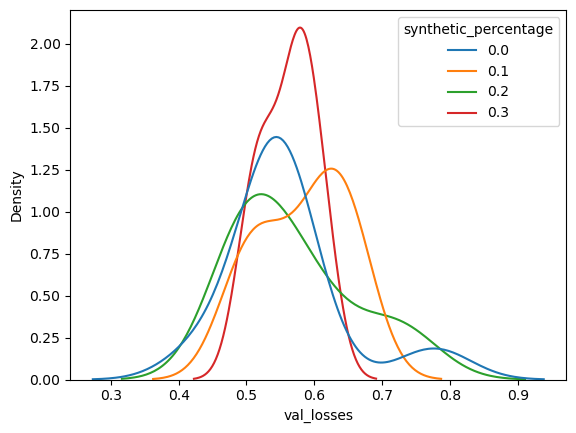

In [222]:
import seaborn as sns

sns.kdeplot(
    data=df_all_results[(df_all_results['train_percentage']==1.0) & (df_all_results['epoch']==6)],
    x='val_losses',
    hue='synthetic_percentage',
    palette=sns.color_palette("tab10")
)


/var/folders/kc/22nrcfyj26bfczb8g410jks40000gn/T/ipykernel_48021/962333127.py:1: UserWarning: The palette list has more values (10) than needed (1), which may not be intended.
  sns.lineplot(


<Axes: xlabel='epoch', ylabel='val_losses'>

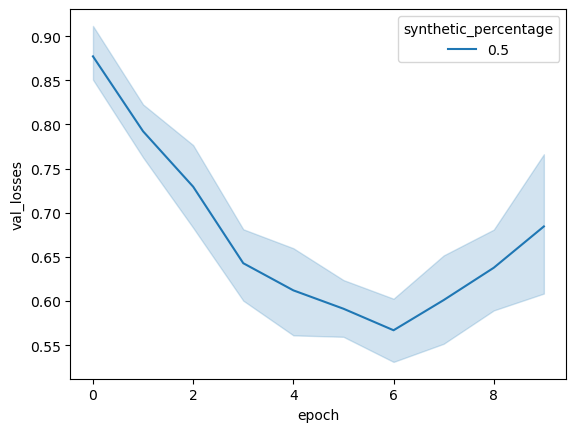

In [229]:
sns.lineplot(
    data=df_all_results[(df_all_results['train_percentage'] == 0.5)  & 
                        (df_all_results['synthetic_percentage'] == 0.5) & 
                        (df_all_results['epoch']<10)],
    x='epoch',
    y='val_losses',
    palette=sns.color_palette("tab10"),
    hue='synthetic_percentage'
)

/var/folders/kc/22nrcfyj26bfczb8g410jks40000gn/T/ipykernel_48021/1960804115.py:1: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.lineplot(


<Axes: xlabel='epoch', ylabel='val_losses'>

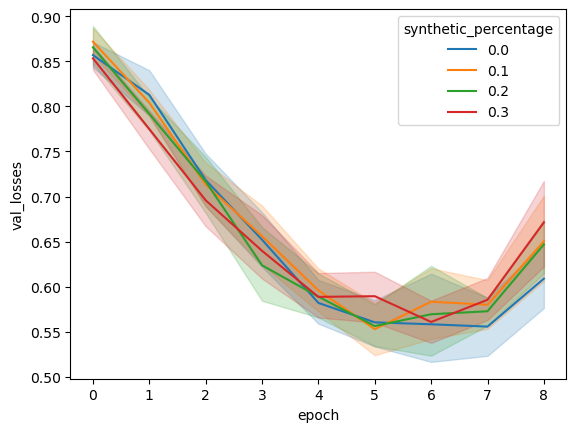

In [232]:
sns.lineplot(
    data=df_all_results[(df_all_results['train_percentage']==1.0) & (df_all_results['epoch']<=8)],
    x='epoch',
    y='val_losses',
    hue='synthetic_percentage',
    palette=sns.color_palette("tab10")
)

In [242]:
df_all_results[df_all_results['epoch']==6].groupby(['train_percentage','synthetic_percentage']).median()

sim_num epoch  val_losses  train_losses  \
train_percentage synthetic_percentage                                           
0.5              0.5                      4.5   6.0    0.589039      0.289707   
0.6              0.4                      4.5   6.0    0.572457      0.295589   
0.7              0.3                      4.5   6.0    0.558913      0.314875   
0.8              0.2                      4.5   6.0    0.519537      0.283490   
0.9              0.1                      4.5   6.0    0.548423      0.289950   
1.0              0.0                      4.5   6.0    0.539187      0.281281   
                 0.1                      4.5   6.0    0.597631      0.302992   
                 0.2                      4.5   6.0    0.537742      0.278102   
                 0.3                      4.5   6.0    0.574329      0.249738   

                                       val_accuracies  
train_percentage synthetic_percentage                  
0.5              0.5                         0.755264  
0.6              0.4                         0.756860  
0.7              0.3                         0.751619  
0.8              0.2                         0.769567  
0.9              0.1                         0.760025  
1.0              0.0                         0.766348  
                 0.1                         0.767907  
                 0.2                         0.776789  
                 0.3                         0.776903

In [244]:
0.776789/0.766348-1

0.013624358646463275

In [209]:
df_all_results[(df_all_results['train_percentage']+ df_all_results['synthetic_percentage']==1.0) & (df_all_results['epoch']==9)].groupby(by=["train_percentage","synthetic_percentage"]).median()

,,sim_num,epoch,val_losses,train_losses,val_accuracies
train_percentage,synthetic_percentage,,,,,
0.5,0.5,4.5,9.0,0.674134,0.136815,0.781623
0.6,0.4,4.5,9.0,0.690912,0.144662,0.771522
0.7,0.3,4.5,9.0,0.646835,0.141731,0.786741
0.8,0.2,4.5,9.0,0.637610,0.114077,0.789433
0.9,0.1,4.5,9.0,0.707602,0.097308,0.789408
1.0,0.0,4.5,9.0,0.651474,0.102069,0.777864


In [ ]:
import matplotlib.pyplot as plt
#0.2543
# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Training and Validation Losses per Epoch")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title("Validation Accuracy per Epoch")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Calculate the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(all_labels, all_preds)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.load_state_dict(torch.load('best_model.pth')) # This line uses .load() to read a .pth file and load the network weights on to the architecture.
model.eval() # enabling the eval mode to test with new samples.

In [ ]:
inputs = torch.randn(1,1,128,128)
inputs = inputs.to(device) # You can move your input to gpu, torch defaults to cpu

# Run forward pass
with torch.no_grad():
    output = model(inputs)

_, pred = torch.max(output, 1)

pred


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score


# Storage for predictions and actual labels
all_preds = []
all_labels = []

# Evaluation loop
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists to arrays for metric calculation
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate metrics for each class
for class_index in range(4):  # Replace num_classes with the actual number of classes
    class_preds = (all_preds == class_index)
    class_labels = (all_labels == class_index)
    accuracy = accuracy_score(class_labels, class_preds)
    precision = precision_score(class_labels, class_preds, zero_division=0)
    recall = recall_score(class_labels, class_preds, zero_division=0)

    class_name = class_names[class_index]

    print(f"Class name {class_name}({class_index}) - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")

cm = confusion_matrix(all_labels, all_preds)
print(cm)

In [ ]:
# Load the image and preprocess it
from PIL import Image

image = Image.open(r"data/alzheimer_mri/train/ModerateDemented/ModerateDemented_0.png")
image_tensor = transform(image).unsqueeze(0).to(device)

#def pred_class(image_tensor):
img_im = image_tensor.unsqueeze(0).to(device)
#uinput = Variable(img_im)
#uinput = uinput.to(device)
out = model(uinput)

index = out.data.cpu().numpy().argmax()
index

In [ ]:
pred_class(image_tensor)